# Learning phase

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [4]:
games_details = pd.read_csv('../dataset/complete_dataset.csv', low_memory=False)
rows_to_drop = games_details[games_details.isin([-1]).any(axis=1)].index
games_details.drop(rows_to_drop, inplace=True)
games_details = games_details.reset_index(drop=True)
games_details.drop(columns=['GAME_ID', 'DATE'], inplace=True)
games_details.head()

,TEAM_ID,PLAYER_ID,FG3M,DATE_DIFF,OPPOSING_TEAM,WINRATE,AVERAGE_TRIPLES,LOCATION,SEASON
0,1.610613e+09,2594.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
1,1.610613e+09,2223.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
2,1.610613e+09,2584.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
3,1.610613e+09,1890.0,1.0,4.0,1610612759,0.666667,0.0,Away,2003.0
4,1.610613e+09,2207.0,0.0,4.0,1610612759,0.666667,1.0,Away,2003.0


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
#games_details = games_details.sample(frac=0.5)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()
games_details = games_details.reset_index(drop=True)

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])

In [7]:
num_folds = 10
n_jobs = -1
n_estimators = 500

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'max_features': ['sqrt', 'log2', p]
    
}

rf_regressor = RandomForestRegressor(n_estimators = n_estimators, n_jobs=n_jobs)
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 3}


In [8]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
RSS_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = n_estimators, max_features = rf_best_params['max_features'], n_jobs=n_jobs)
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    current_rf_rmse = np.sqrt(current_rf_mse)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse, current_rf_rmse]

    importances = rf_regressor.feature_importances_
    RSS_importances.loc[fold] = importances

In [9]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)
    current_dummy_rmse = np.sqrt(current_dummy_mse)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse, current_dummy_rmse]

In [10]:
knn_param_grid = {
    'n_neighbors': [1, 5, 50, 150],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 150, 'p': 1}


In [11]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    current_knn_rmse = np.sqrt(current_knn_mse)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse, current_knn_rmse]

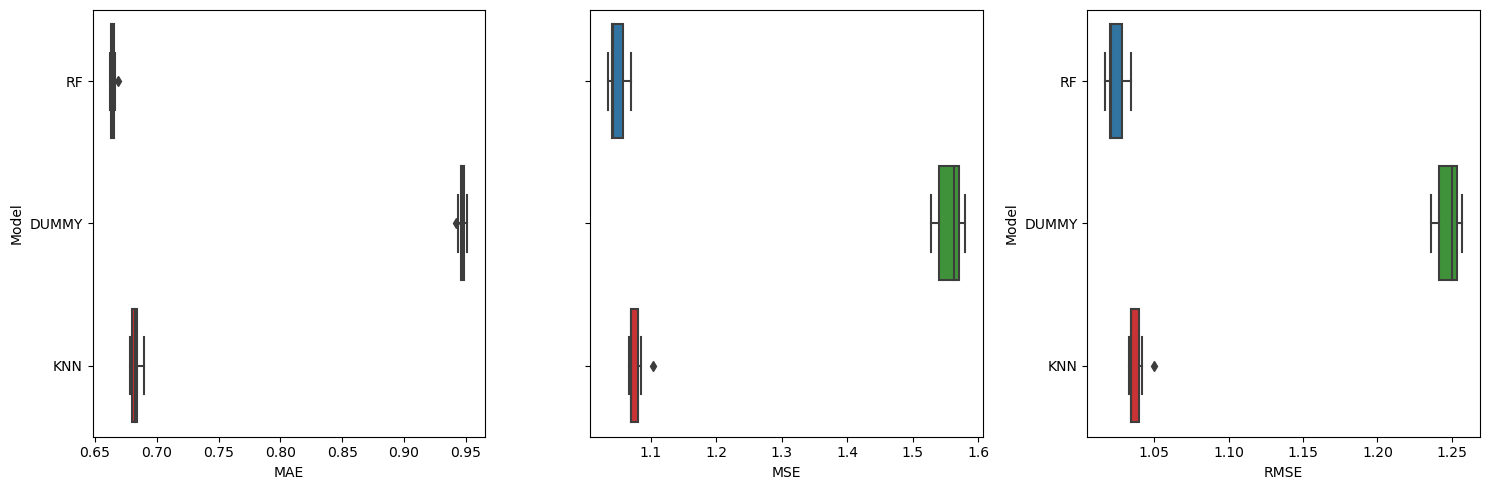

In [22]:
fig, axs = plt.subplots(1, 3, figsize= (15, 5))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", ax=axs[1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[2], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.savefig('./images/errors.pdf')
plt.show()

# Adjust figsize if needed

In [ ]:
from pandas.plotting import table
summary_errors = reg_metrics.groupby('Model').agg({'MAE': ['mean', 'std'],
                                      'MSE': ['mean', 'std'],
                                      'RMSE': ['mean', 'std']}).reset_index()

summary_errors.columns = ['Model', 'Mean MAE', 'Std MAE', 'Mean MSE', 'Std MSE', 'Mean RMSE', 'Std RMSE']
summary_errors.to_csv('output/errors.csv', index=False)
display(summary_errors)

In [ ]:
print(RSS_importances)
melted_RSS = RSS_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(12, 5))
sns.boxplot(x='Column', y='value', data=melted_RSS, palette='Set3')
#sns.boxplot(x='Column', y='value', data=melted_RSS, hue='Column', palette='Set3')

plt.title('Boxplot of variables importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()

In [15]:
summary_RSS = RSS_importances.agg(['mean', 'std']).transpose().reset_index()
summary_RSS.columns = ['Column', 'Average', 'Standard Deviation']
summary_RSS.to_csv('images/RSS_decrease.csv', index=False)
display(summary_RSS)

,Column,Average,Standard Deviation
0,TEAM_ID,0.055922,0.000176
1,PLAYER_ID,0.091323,0.000193
2,DATE_DIFF,0.058041,0.000287
3,OPPOSING_TEAM,0.148123,0.000219
4,WINRATE,0.049076,0.000368
5,AVERAGE_TRIPLES,0.505702,0.000476
6,LOCATION,0.028663,0.000133
7,SEASON,0.063151,0.000261


In [25]:
# Print the error values for the current fold
print(f"Fold {fold + 1} - MAE: {current_rf_mae}, MSE: {current_rf_mse}, RMSE: {current_rf_rmse}")

# If you want to see the final metrics DataFrame
print(reg_metrics)


Fold 10 - MAE: 0.6625392415020016, MSE: 1.0411347021467057, RMSE: 1.0203600845518732
    Model       MAE       MSE      RMSE
0      RF  0.668845  1.068663  1.033761
1      RF  0.662828  1.043496  1.021517
2      RF  0.665361  1.070728  1.034760
3      RF  0.664328  1.034697  1.017201
4      RF  0.664415  1.058022  1.028602
5      RF  0.663203  1.038540  1.019088
6      RF  0.666118  1.057087  1.028148
7      RF  0.663910  1.041113  1.020349
8      RF  0.662695  1.042085  1.020826
9      RF  0.662539  1.041135  1.020360
10  DUMMY  0.947985  1.562415  1.249966
11  DUMMY  0.949016  1.573599  1.254432
12  DUMMY  0.948972  1.575379  1.255141
13  DUMMY  0.946536  1.532067  1.237767
14  DUMMY  0.947445  1.563955  1.250582
15  DUMMY  0.947133  1.559513  1.248804
16  DUMMY  0.951349  1.579755  1.256883
17  DUMMY  0.943763  1.534468  1.238737
18  DUMMY  0.941951  1.527896  1.236081
19  DUMMY  0.946181  1.564597  1.250839
20    KNN  0.682786  1.069314  1.034077
21    KNN  0.689668  1.102940  1.05

In [26]:
# Group by model and calculate the mean and standard deviation for each metric
metrics_summary = reg_metrics.groupby('Model').agg(['mean', 'std'])

# Display the results
print(metrics_summary)

            MAE                 MSE                RMSE          
           mean       std      mean       std      mean       std
Model                                                            
DUMMY  0.947033  0.002686  1.557364  0.018997  1.247923  0.007623
KNN    0.682709  0.003565  1.076665  0.011159  1.037612  0.005359
RF     0.664424  0.001948  1.049557  0.012990  1.024461  0.006329
